<a href="https://colab.research.google.com/github/ericaong97/DeepLearningLLM/blob/main/weightdecay_0_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ericaong97/DeepLearningLLM.git
%cd DeepLearningLLM

Cloning into 'DeepLearningLLM'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 65 (delta 21), reused 49 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 652.27 KiB | 5.48 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/DeepLearningLLM


In [3]:
!pip install -r requirements.txt  # If there's a requirements file
# Otherwise install dependencies like
!pip install transformers datasets torch accelerate peft

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [4]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=634926df499e8b9c756c8ae52948ef931f2171e44a101b9d192d10b957c875f9
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [5]:
!python data_utils.py

In [5]:
# optimizer_and_scheduler.py
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Optimizer setup
def get_optimizer(model):
    return AdamW(
        model.parameters(),
        lr=2e-4,
        eps=1e-6,
        weight_decay=0.05
    )

# 2. Plateau scheduler
def get_plateau_scheduler(optimizer):
    return ReduceLROnPlateau(optimizer, mode='min',
                            patience=2,
                            factor=0.5,
                            threshold=0.01,
                            threshold_mode='rel',
                            min_lr=1e-5)

# 3. Teacher Forcing Ratio Class
class TeacherForcingScheduler:
    def __init__(self, initial_ratio=0.9, min_ratio=0.1,
                decay_type='exp', decay_steps=4487*8,
                decay_rate=0.9998, staircase=False):
        """
        Args:
            decay_type: 'exp' (exponential) or 'linear'
            decay_steps: Steps to decay from initial→min_ratio
            staircase: If True, decay at discrete intervals
        """
        self.initial_ratio = initial_ratio
        self.min_ratio = min_ratio
        self.decay_type = decay_type
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.staircase = staircase
        self._step = 0  # Critical for resuming

    def step(self):
        """Call this EVERY batch update"""
        self._step += 1

        if self.decay_type == 'linear':
            ratio = self.initial_ratio - (self.initial_ratio - self.min_ratio) * (min(1.0, self._step / self.decay_steps))
        else:  # exponential
            if self.staircase:
                ratio = self.initial_ratio * (self.decay_rate ** (self._step // self.decay_steps))
            else:
                ratio = self.initial_ratio * (self.decay_rate**self._step)

        self.current_ratio = max(ratio, self.min_ratio)
        return self.current_ratio

    def state_dict(self):
        return {k: v for k, v in self.__dict__.items()}

    def load_state_dict(self, state_dict):
        self.__dict__.update(state_dict)


# 4. Exponential decay teacher forcing
exp_teacher_scheduler = TeacherForcingScheduler(
    initial_ratio=0.9,
    min_ratio=0.1,
    decay_rate=0.9998,  # Reaches 0.1 after ~2 epochs
    decay_steps=4487*8)

# 5. Linear decay teacher forcing
linear_teacher_scheduler = TeacherForcingScheduler(
    decay_type='linear',
    decay_steps=4487*6  # Full decay after 8 epochs
)

In [4]:
!python baseline_transformer_architecture.py

In [5]:
!python modeling_functions.py

Traceback (most recent call last):
  File "/content/DeepLearningLLM/modeling_functions.py", line 4, in <module>
    from rouge_score import rouge_scorer
ModuleNotFoundError: No module named 'rouge_score'


In [8]:
# import libraries and modules
import torch
from data_utils import (
    get_train_loader,
    get_val_loader,
    set_seed
)
from baseline_transformer_architecture import create_small_transformer

from modeling_functions import (
    train_transformer_teacher_forcing
)

from optimizer_scheduler import (
    get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
)
from tokenizers import Tokenizer

# ============================================================================

# 1. Setting a global seed and device to use
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define model configuration
config = {
    "vocab_size": 20000,
    "dropout": 0.1,
    "max_len": 512,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    "dim_feedforward": 2048
}


# 2. load the tokenizer
tokenizer_20 = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")


# 3. Initialize model
base_model = create_small_transformer(d_model=config['d_model'],
                                nhead=config['nhead'],
                                num_decoder_layers=config['num_decoder_layers'],
                                num_encoder_layers=config['num_encoder_layers'],
                                dim_feedforward=config['dim_feedforward'],
                                dropout=config['dropout'],
                                vocab_size=config['vocab_size']).to(device)

# 4. Data loading
train_loader = get_train_loader(tokenizer=tokenizer_20)
val_loader = get_val_loader(tokenizer=tokenizer_20)

# 5. Define criterion
# It ignores the padding index
transformer_criterion = torch.nn.CrossEntropyLoss(ignore_index=1)

# 6. Training Loop
# please change the filename for your experiment
history = train_transformer_teacher_forcing(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=get_optimizer(base_model),
    criterion=transformer_criterion,
    plateau_scheduler=get_plateau_scheduler(get_optimizer(base_model)),
    teacher_forcing_scheduler=linear_teacher_scheduler,
    tokenizer=tokenizer_20,
    device=device,
    pad_idx=tokenizer_20.token_to_id("[PAD]"),
    clip_norm=2.0,
    num_epochs=5,
    max_length_generate=40,
    filename='test_weightdecay'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Epoch 1/5:   0%|          | 0/4487 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch 1/5 Summary:
Train Loss: 6.3234 | Val Loss: 5.3936
ROUGE Scores: 0.1325/0.0162/0.1124
Learning Rate: 2.00e-04 | TF Ratio: 0.90


Epoch 2/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 2/5 Summary:
Train Loss: 5.3834 | Val Loss: 4.8190
ROUGE Scores: 0.1585/0.0232/0.1328
Learning Rate: 2.00e-04 | TF Ratio: 0.90


Epoch 3/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 3/5 Summary:
Train Loss: 5.1307 | Val Loss: 4.5786
ROUGE Scores: 0.1704/0.0270/0.1379
Learning Rate: 2.00e-04 | TF Ratio: 0.77


Epoch 4/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 4/5 Summary:
Train Loss: 5.2254 | Val Loss: 4.4638
ROUGE Scores: 0.1776/0.0287/0.1411
Learning Rate: 2.00e-04 | TF Ratio: 0.63


Epoch 5/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 5/5 Summary:
Train Loss: 5.3455 | Val Loss: 4.4397
ROUGE Scores: 0.1782/0.0311/0.1438
Learning Rate: 2.00e-04 | TF Ratio: 0.50


In [16]:
# libraries for inference
import torch
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import generate_with_beam_search,calculate_and_save_rouge
from tokenizers import Tokenizer
from data_utils import get_test_loader,set_seed

# 1. Configuration setup
set_seed(42)
config = {
    "vocab_size": 20000,
    "dropout": 0.1,
    "max_len": 512,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    "dim_feedforward": 2048
}

# 2. Load the tokenizer
tokenizer_20 = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")  # Make sure this is the correct path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_idx = tokenizer_20.token_to_id("[PAD]")

# 3. Recreate the model architecture
loaded_model = create_small_transformer(d_model=config['d_model'],
                                nhead=config['nhead'],
                                num_decoder_layers=config['num_decoder_layers'],
                                num_encoder_layers=config['num_encoder_layers'],
                                dim_feedforward=config['dim_feedforward'],
                                dropout=config['dropout'],
                                vocab_size=config['vocab_size']).to(device)

# 4. Load the saved state dictionary
# change the file based on your model name
loaded_model.load_state_dict(torch.load('test_weightdecay_final_model.pt'))
loaded_model = loaded_model.to(device)

# 5. Set the model to evaluation mode
loaded_model.eval()

# 6. Load dataset
test_loader = get_test_loader(tokenizer_20)  #  Use the tokenizer_20 instance

# 7. Get a batch of data based on number of samples selected
num_examples_to_show = 5
generated_summaries = []
reference_summaries = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        # 1. Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 2. Verify special tokens (do this once before the loop)
        if i == 0:  # Only print once
            print("[DEBUG] Special tokens:")
            print(f"[PAD]: {tokenizer_20.token_to_id('[PAD]')} -> '{tokenizer_20.decode([tokenizer_20.token_to_id('[PAD]')])}'")
            print(f"[SOS]: {tokenizer_20.token_to_id('[SOS]')}")
            print(f"[EOS]: {tokenizer_20.token_to_id('[EOS]')}")
            print(f"Dot token: {tokenizer_20.token_to_id('.')} -> '{tokenizer_20.decode([tokenizer_20.token_to_id('.')])}'")

        generated_summary = generate_with_beam_search(
                            model=loaded_model,
                            input_ids=input_ids[0],  # Single sequence
                            tokenizer=tokenizer_20,
                            device=device,
                            beam_width=3,
                            max_length=40
                )

        # 4. Decode references
        actual_summary = tokenizer_20.decode(
            labels[0].tolist(),
            skip_special_tokens=True
        )
        input_article = tokenizer_20.decode(
            input_ids[0].tolist(),
            skip_special_tokens=True
        )

        # Store for ROUGE calculation
        generated_summaries.append(generated_summary)
        reference_summaries.append(actual_summary)

        # 5. Print results
        # print(f"\n--- Example {i+1} ---")
        # print(f"Input: {input_article[:200]}...")  # Truncate long inputs
        # print(f"Generated Summary: {generated_summary}")
        # print(f"Actual Summary: {actual_summary}")
        # print("-" * 50)

        if i + 1 >= num_examples_to_show:
            break

# 8. Generating final rouge scores
# change the output_path for your own experiments
rouge_results = calculate_and_save_rouge(
    generated_summaries=generated_summaries,
    reference_summaries=reference_summaries,
    output_path="weightdecay_rouge_scores.json"
)

[DEBUG] Special tokens:
[PAD]: 1 -> ''
[SOS]: 2
[EOS]: 3
Dot token: 17 -> '.'


Saved training dynamics plot to weightdecay_losses.png


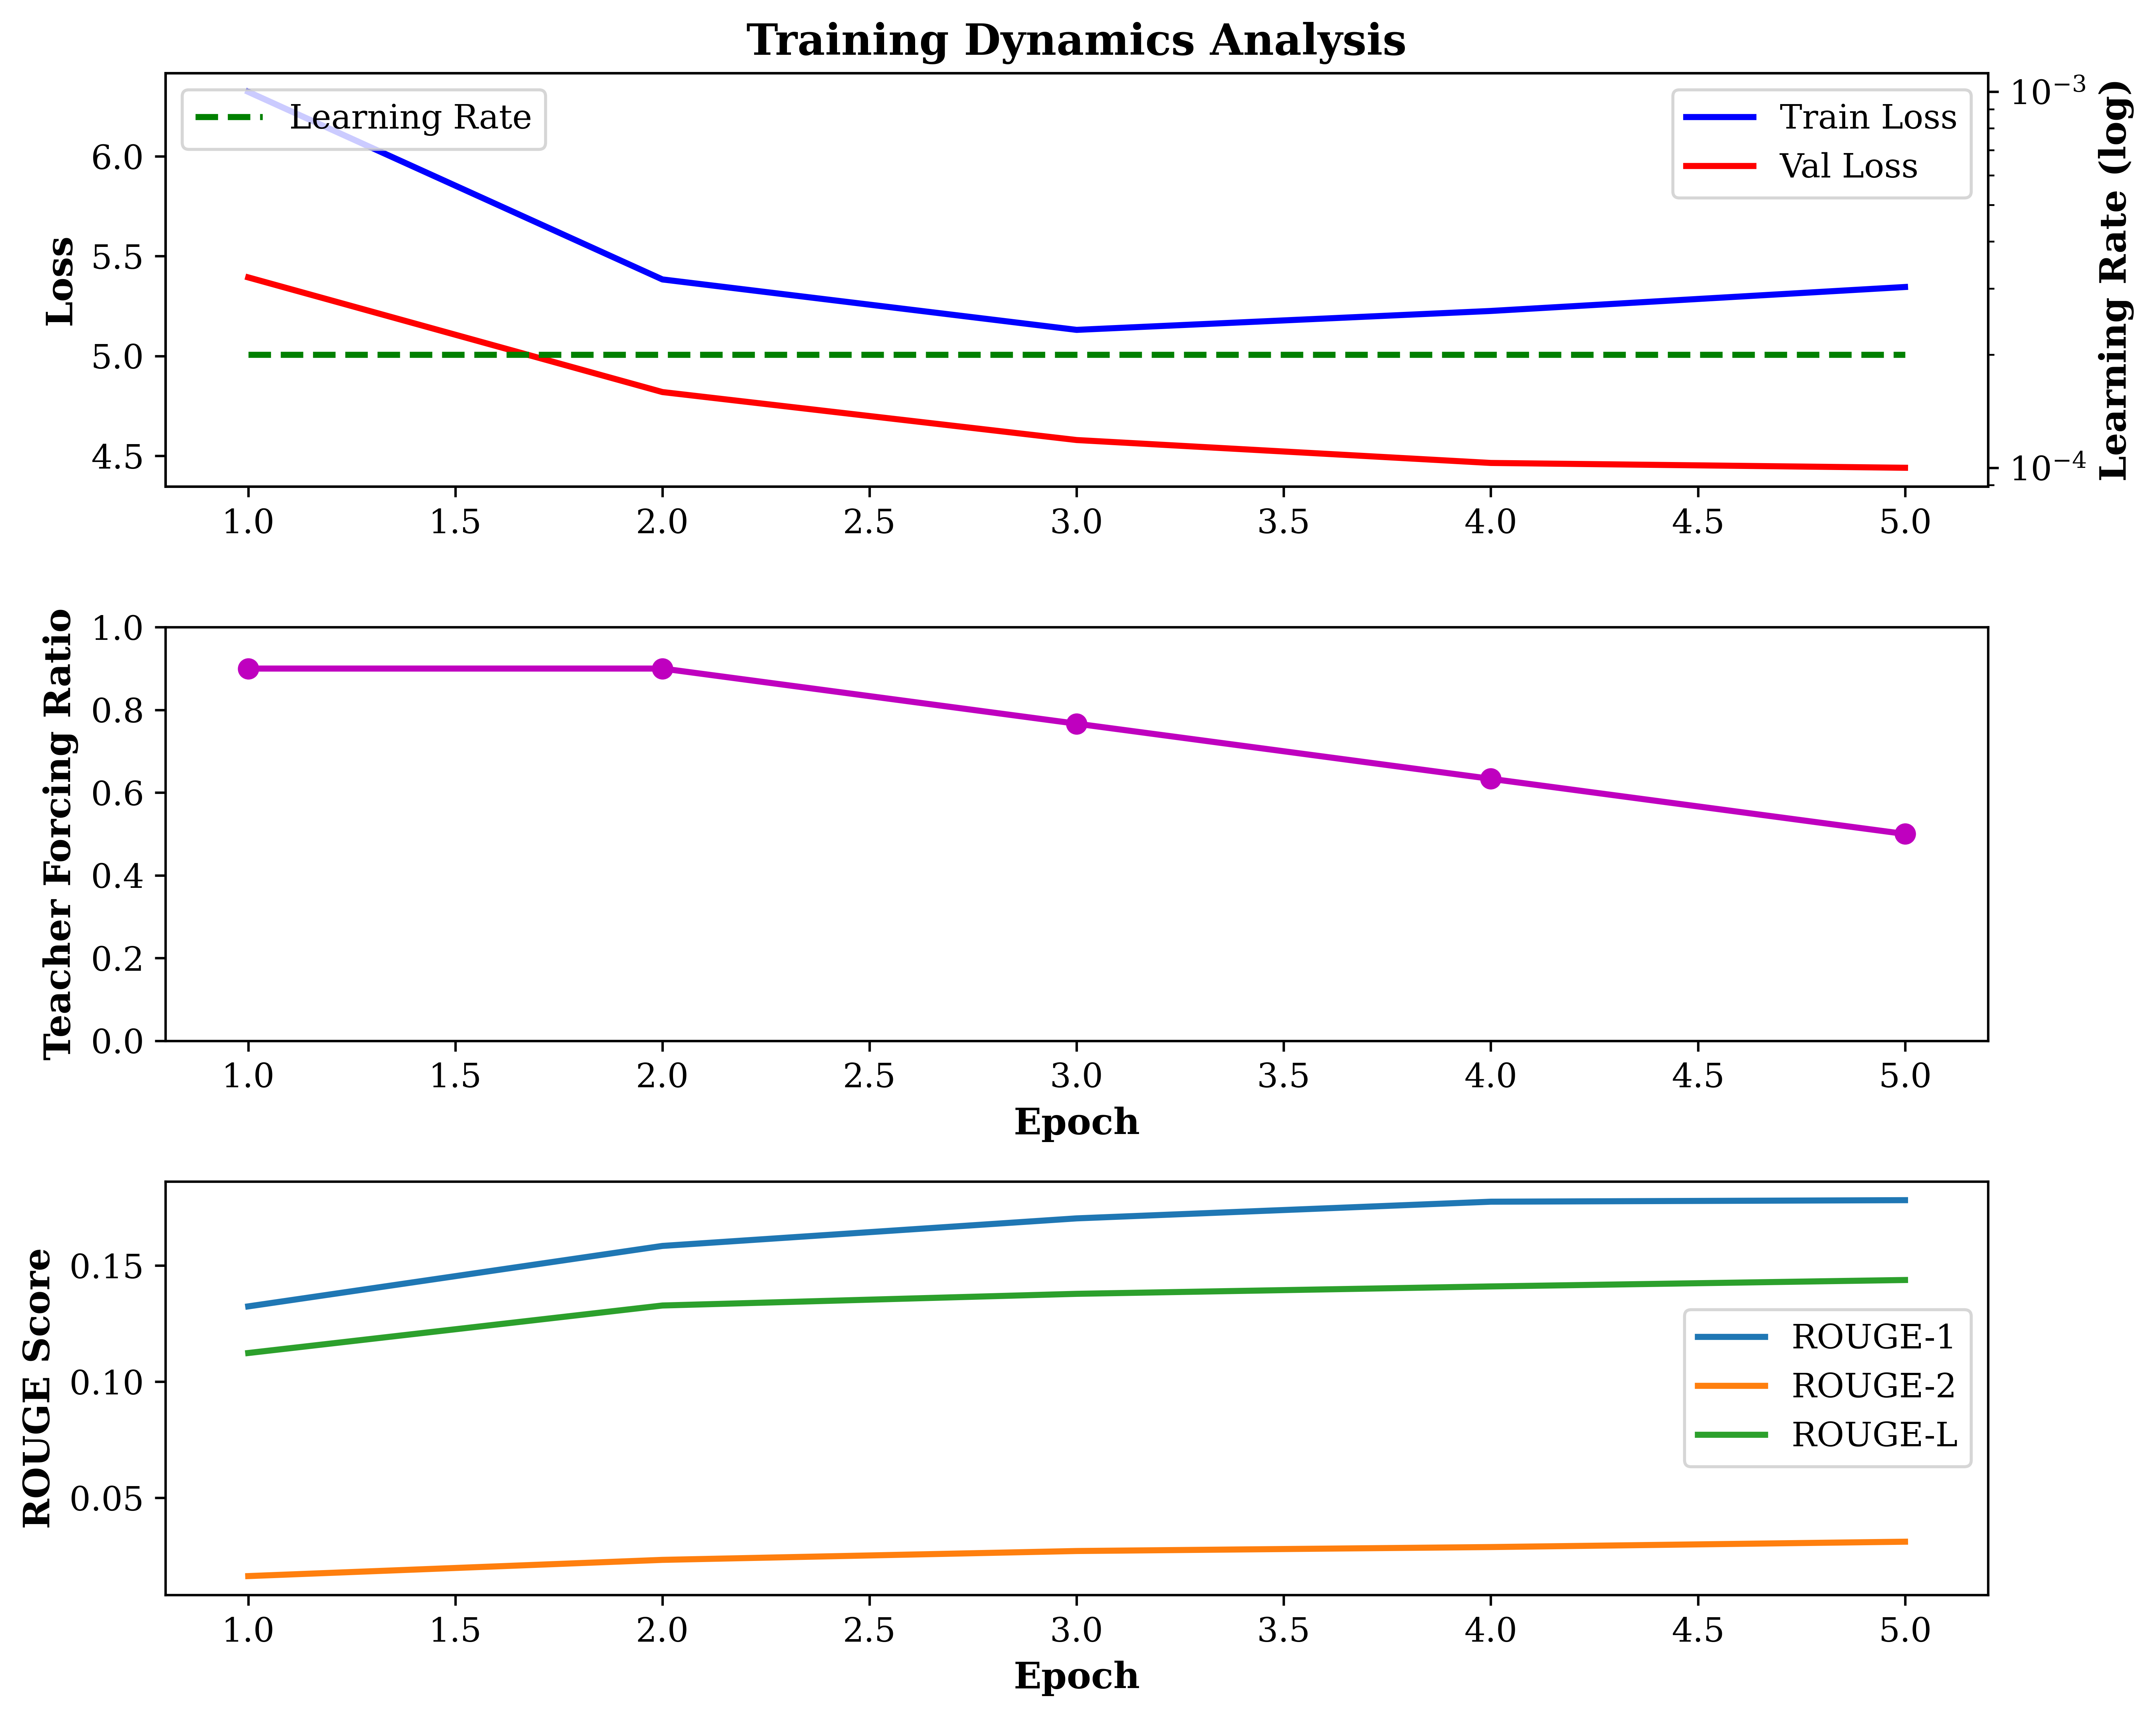

In [11]:
"""
training_visualization.py - Visualization utilities for training metrics
"""
import matplotlib.pyplot as plt
import numpy as np
import json

# 1. loading JSON data
def load_history(json_path):
    with open(json_path) as f:
        return json.load(f)

# 2. Visualization in long form
def visualize_training_dynamics(history, save_path=None):
    """
    Enhanced visualization showing:
    - Loss curves (train/val)
    - Learning rate schedule
    - Teacher forcing ratio
    - All aligned by epoch for comparison

    Args:
        history: Dictionary containing training history
        save_path: Optional path to save the figure
    """
    # Set larger font sizes
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11
    })

    plt.figure(figsize=(10, 8))
    epochs = np.arange(1, len(history['train_loss']) + 1)

    # Create main axis for loss
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Val Loss')
    ax1.set_ylabel('Loss', fontweight='bold')
    ax1.set_title('Training Dynamics Analysis', fontweight='bold')
    ax1.legend(loc='upper right')

    # Create twin axis for learning rate (log scale)
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['learning_rate'], 'g--', linewidth=2, label='Learning Rate')
    ax2.set_yscale('log')
    ax2.set_ylabel('Learning Rate (log)', fontweight='bold')
    ax2.legend(loc='upper left')

    # Teacher forcing ratio plot
    ax3 = plt.subplot(3, 1, 2)
    ax3.plot(epochs, history['teacher_forcing_ratio'], 'm-', marker='o', markersize=6, linewidth=2)
    ax3.set_ylabel('Teacher Forcing Ratio', fontweight='bold')
    ax3.set_xlabel('Epoch', fontweight='bold')
    ax3.set_ylim(0, 1)

    # ROUGE scores plot (if any non-zero values)
    if any(v > 0 for v in history['rouge1'] + history['rouge2'] + history['rougeL']):
        ax4 = plt.subplot(3, 1, 3)
        ax4.plot(epochs, history['rouge1'], linewidth=2, label='ROUGE-1')
        ax4.plot(epochs, history['rouge2'], linewidth=2, label='ROUGE-2')
        ax4.plot(epochs, history['rougeL'], linewidth=2, label='ROUGE-L')
        ax4.set_ylabel('ROUGE Score', fontweight='bold')
        ax4.set_xlabel('Epoch', fontweight='bold')
        ax4.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved training dynamics plot to {save_path}")
    plt.show()

# 3. Visualization for 2-columned AAAI
def visualize_aaai_twocolumn(history, save_path='training_plot.png'):
    """
    AAAI 2-column formatted visualization (PNG output)
    Optimized for LaTeX documents with:
    - 3.5" width (fits single column)
    - 600 DPI resolution
    - Transparent background
    - Anti-aliased text
    """
    # Set up figure with exact dimensions
    plt.figure(figsize=(3.5, 4.0))  # Width: 3.5", Height: 4.0"

    # Configure fonts and styles
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'font.family': 'serif',
        'text.usetex': False,  # Set to True if you have LaTeX installed
        'figure.dpi': 600,
        'savefig.dpi': 600,
        'savefig.transparent': True
    })

    epochs = np.arange(1, len(history['train_loss']) + 1)

    # Main loss plot
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(epochs, history['train_loss'], color='#1f77b4', linestyle='-',
            linewidth=1.5, label='Train')
    ax1.plot(epochs, history['val_loss'], color='#d62728', linestyle='--',
            linewidth=1.5, label='Val')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend(frameon=True, framealpha=1, edgecolor='black')

    # Optimization parameters
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(epochs, history['learning_rate'], color='#2ca02c',
            linestyle='-', linewidth=1.5, label='LR')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate', color='#2ca02c')
    ax2.tick_params(axis='y', labelcolor='#2ca02c')
    ax2.grid(True, alpha=0.3)

    ax3 = ax2.twinx()
    ax3.plot(epochs, history['teacher_forcing_ratio'], color='#9467bd',
            linestyle=':', linewidth=1.5, label='TF Ratio')
    ax3.set_ylabel('TF Ratio', color='#9467bd')
    ax3.tick_params(axis='y', labelcolor='#9467bd')

    # Combined legend
    lines = [ax2.get_lines()[0], ax3.get_lines()[0]]
    ax2.legend(lines, [l.get_label() for l in lines],
                frameon=True, framealpha=1, edgecolor='black')

    plt.tight_layout(pad=0.8)

    # Save with exact dimensions and high quality
    if save_path:
        plt.savefig(
            save_path,
            format='png',
            bbox_inches='tight',
            pad_inches=0.05,
            transparent=True,
            dpi=600
        )
        print(f"Saved publication-ready figure to {save_path}")
    plt.close()  # Close the figure to free memory

# ==============================================
# MAIN EXECUTION BLOCK (for standalone usage)
# ==============================================
if __name__ == "__main__":
    # Example usage when run directly: please change to your file name and desired picture name for output
    history = load_history("/content/DeepLearningLLM/test_weightdecay_history.json")
    # visualize_aaai_twocolumn(history, save_path="sample_training_plot_2.png")
    visualize_training_dynamics(history, save_path="weightdecay_losses.png")

Weight decay = 0.025

In [1]:
# optimizer_and_scheduler.py
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Optimizer setup
def get_optimizer(model):
    return AdamW(
        model.parameters(),
        lr=2e-4,
        eps=1e-6,
        weight_decay=0.0
    )

# 2. Plateau scheduler
def get_plateau_scheduler(optimizer):
    return ReduceLROnPlateau(optimizer, mode='min',
                            patience=2,
                            factor=0.5,
                            threshold=0.01,
                            threshold_mode='rel',
                            min_lr=1e-5)

# 3. Teacher Forcing Ratio Class
class TeacherForcingScheduler:
    def __init__(self, initial_ratio=0.9, min_ratio=0.1,
                decay_type='exp', decay_steps=4487*8,
                decay_rate=0.9998, staircase=False):
        """
        Args:
            decay_type: 'exp' (exponential) or 'linear'
            decay_steps: Steps to decay from initial→min_ratio
            staircase: If True, decay at discrete intervals
        """
        self.initial_ratio = initial_ratio
        self.min_ratio = min_ratio
        self.decay_type = decay_type
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.staircase = staircase
        self._step = 0  # Critical for resuming

    def step(self):
        """Call this EVERY batch update"""
        self._step += 1

        if self.decay_type == 'linear':
            ratio = self.initial_ratio - (self.initial_ratio - self.min_ratio) * (min(1.0, self._step / self.decay_steps))
        else:  # exponential
            if self.staircase:
                ratio = self.initial_ratio * (self.decay_rate ** (self._step // self.decay_steps))
            else:
                ratio = self.initial_ratio * (self.decay_rate**self._step)

        self.current_ratio = max(ratio, self.min_ratio)
        return self.current_ratio

    def state_dict(self):
        return {k: v for k, v in self.__dict__.items()}

    def load_state_dict(self, state_dict):
        self.__dict__.update(state_dict)


# 4. Exponential decay teacher forcing
exp_teacher_scheduler = TeacherForcingScheduler(
    initial_ratio=0.9,
    min_ratio=0.1,
    decay_rate=0.9998,  # Reaches 0.1 after ~2 epochs
    decay_steps=4487*8)

# 5. Linear decay teacher forcing
linear_teacher_scheduler = TeacherForcingScheduler(
    decay_type='linear',
    decay_steps=4487*6  # Full decay after 8 epochs
)

In [6]:
# import libraries and modules
import torch
from data_utils import (
    get_train_loader,
    get_val_loader,
    set_seed
)
from baseline_transformer_architecture import create_small_transformer

from modeling_functions import (
    train_transformer_teacher_forcing
)

from optimizer_scheduler import (
    get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
)
from tokenizers import Tokenizer

# ============================================================================

# 1. Setting a global seed and device to use
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Define model configuration
config = {
    "vocab_size": 20000,
    "dropout": 0.1,
    "max_len": 512,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    "dim_feedforward": 2048
}


# 2. load the tokenizer
tokenizer_20 = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")


# 3. Initialize model
base_model = create_small_transformer(d_model=config['d_model'],
                                nhead=config['nhead'],
                                num_decoder_layers=config['num_decoder_layers'],
                                num_encoder_layers=config['num_encoder_layers'],
                                dim_feedforward=config['dim_feedforward'],
                                dropout=config['dropout'],
                                vocab_size=config['vocab_size']).to(device)

# 4. Data loading
train_loader = get_train_loader(tokenizer=tokenizer_20)
val_loader = get_val_loader(tokenizer=tokenizer_20)

# 5. Define criterion
# It ignores the padding index
transformer_criterion = torch.nn.CrossEntropyLoss(ignore_index=1)

# 6. Training Loop
# please change the filename for your experiment
history = train_transformer_teacher_forcing(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=get_optimizer(base_model),
    criterion=transformer_criterion,
    plateau_scheduler=get_plateau_scheduler(get_optimizer(base_model)),
    teacher_forcing_scheduler=linear_teacher_scheduler,
    tokenizer=tokenizer_20,
    device=device,
    pad_idx=tokenizer_20.token_to_id("[PAD]"),
    clip_norm=2.0,
    num_epochs=5,
    max_length_generate=40,
    filename='test_nodecay'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Epoch 1/5:   0%|          | 0/4487 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch 1/5 Summary:
Train Loss: 6.3231 | Val Loss: 5.3785
ROUGE Scores: 0.1364/0.0172/0.1162
Learning Rate: 2.00e-04 | TF Ratio: 0.90


Epoch 2/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 2/5 Summary:
Train Loss: 5.3801 | Val Loss: 4.8295
ROUGE Scores: 0.1550/0.0231/0.1301
Learning Rate: 2.00e-04 | TF Ratio: 0.90


Epoch 3/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 3/5 Summary:
Train Loss: 5.1262 | Val Loss: 4.6339
ROUGE Scores: 0.1708/0.0261/0.1389
Learning Rate: 2.00e-04 | TF Ratio: 0.77


Epoch 4/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 4/5 Summary:
Train Loss: 5.2198 | Val Loss: 4.4522
ROUGE Scores: 0.1804/0.0297/0.1445
Learning Rate: 2.00e-04 | TF Ratio: 0.63


Epoch 5/5:   0%|          | 0/4487 [00:00<?, ?it/s]


Epoch 5/5 Summary:
Train Loss: 5.3395 | Val Loss: 4.4752
ROUGE Scores: 0.1882/0.0326/0.1493
Learning Rate: 2.00e-04 | TF Ratio: 0.50


In [8]:
# libraries for inference
import torch
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import generate_with_beam_search,calculate_and_save_rouge
from tokenizers import Tokenizer
from data_utils import get_test_loader,set_seed

# 1. Configuration setup
set_seed(42)
config = {
    "vocab_size": 20000,
    "dropout": 0.1,
    "max_len": 512,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 4,
    "num_decoder_layers": 4,
    "dim_feedforward": 2048
}

# 2. Load the tokenizer
tokenizer_20 = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")  # Make sure this is the correct path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pad_idx = tokenizer_20.token_to_id("[PAD]")

# 3. Recreate the model architecture
loaded_model = create_small_transformer(d_model=config['d_model'],
                                nhead=config['nhead'],
                                num_decoder_layers=config['num_decoder_layers'],
                                num_encoder_layers=config['num_encoder_layers'],
                                dim_feedforward=config['dim_feedforward'],
                                dropout=config['dropout'],
                                vocab_size=config['vocab_size']).to(device)

# 4. Load the saved state dictionary
# change the file based on your model name
loaded_model.load_state_dict(torch.load('test_nodecay_final_model.pt'))
loaded_model = loaded_model.to(device)

# 5. Set the model to evaluation mode
loaded_model.eval()

# 6. Load dataset
test_loader = get_test_loader(tokenizer_20)  #  Use the tokenizer_20 instance

# 7. Get a batch of data based on number of samples selected
num_examples_to_show = 5
generated_summaries = []
reference_summaries = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        # 1. Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 2. Verify special tokens (do this once before the loop)
        if i == 0:  # Only print once
            print("[DEBUG] Special tokens:")
            print(f"[PAD]: {tokenizer_20.token_to_id('[PAD]')} -> '{tokenizer_20.decode([tokenizer_20.token_to_id('[PAD]')])}'")
            print(f"[SOS]: {tokenizer_20.token_to_id('[SOS]')}")
            print(f"[EOS]: {tokenizer_20.token_to_id('[EOS]')}")
            print(f"Dot token: {tokenizer_20.token_to_id('.')} -> '{tokenizer_20.decode([tokenizer_20.token_to_id('.')])}'")

        generated_summary = generate_with_beam_search(
                            model=loaded_model,
                            input_ids=input_ids[0],  # Single sequence
                            tokenizer=tokenizer_20,
                            device=device,
                            beam_width=3,
                            max_length=40
                )

        # 4. Decode references
        actual_summary = tokenizer_20.decode(
            labels[0].tolist(),
            skip_special_tokens=True
        )
        input_article = tokenizer_20.decode(
            input_ids[0].tolist(),
            skip_special_tokens=True
        )

        # Store for ROUGE calculation
        generated_summaries.append(generated_summary)
        reference_summaries.append(actual_summary)

        # 5. Print results
        # print(f"\n--- Example {i+1} ---")
        # print(f"Input: {input_article[:200]}...")  # Truncate long inputs
        # print(f"Generated Summary: {generated_summary}")
        # print(f"Actual Summary: {actual_summary}")
        # print("-" * 50)

        if i + 1 >= num_examples_to_show:
            break

# 8. Generating final rouge scores
# change the output_path for your own experiments
rouge_results = calculate_and_save_rouge(
    generated_summaries=generated_summaries,
    reference_summaries=reference_summaries,
    output_path="zeroweightdecay_rouge_scores.json"
)

[DEBUG] Special tokens:
[PAD]: 1 -> ''
[SOS]: 2
[EOS]: 3
Dot token: 17 -> '.'


Saved training dynamics plot to weightdecay_losses_zero.png


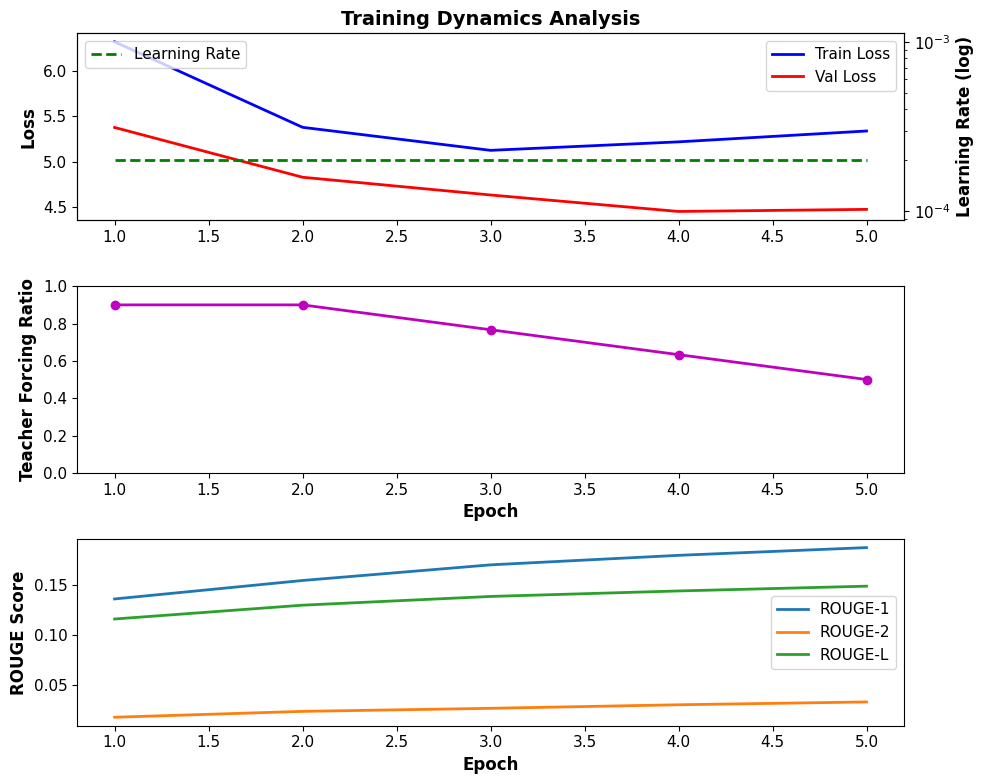

In [10]:
"""
training_visualization.py - Visualization utilities for training metrics
"""
import matplotlib.pyplot as plt
import numpy as np
import json

# 1. loading JSON data
def load_history(json_path):
    with open(json_path) as f:
        return json.load(f)

# 2. Visualization in long form
def visualize_training_dynamics(history, save_path=None):
    """
    Enhanced visualization showing:
    - Loss curves (train/val)
    - Learning rate schedule
    - Teacher forcing ratio
    - All aligned by epoch for comparison

    Args:
        history: Dictionary containing training history
        save_path: Optional path to save the figure
    """
    # Set larger font sizes
    plt.rcParams.update({
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'legend.fontsize': 11
    })

    plt.figure(figsize=(10, 8))
    epochs = np.arange(1, len(history['train_loss']) + 1)

    # Create main axis for loss
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', linewidth=2, label='Val Loss')
    ax1.set_ylabel('Loss', fontweight='bold')
    ax1.set_title('Training Dynamics Analysis', fontweight='bold')
    ax1.legend(loc='upper right')

    # Create twin axis for learning rate (log scale)
    ax2 = ax1.twinx()
    ax2.plot(epochs, history['learning_rate'], 'g--', linewidth=2, label='Learning Rate')
    ax2.set_yscale('log')
    ax2.set_ylabel('Learning Rate (log)', fontweight='bold')
    ax2.legend(loc='upper left')

    # Teacher forcing ratio plot
    ax3 = plt.subplot(3, 1, 2)
    ax3.plot(epochs, history['teacher_forcing_ratio'], 'm-', marker='o', markersize=6, linewidth=2)
    ax3.set_ylabel('Teacher Forcing Ratio', fontweight='bold')
    ax3.set_xlabel('Epoch', fontweight='bold')
    ax3.set_ylim(0, 1)

    # ROUGE scores plot (if any non-zero values)
    if any(v > 0 for v in history['rouge1'] + history['rouge2'] + history['rougeL']):
        ax4 = plt.subplot(3, 1, 3)
        ax4.plot(epochs, history['rouge1'], linewidth=2, label='ROUGE-1')
        ax4.plot(epochs, history['rouge2'], linewidth=2, label='ROUGE-2')
        ax4.plot(epochs, history['rougeL'], linewidth=2, label='ROUGE-L')
        ax4.set_ylabel('ROUGE Score', fontweight='bold')
        ax4.set_xlabel('Epoch', fontweight='bold')
        ax4.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved training dynamics plot to {save_path}")
    plt.show()

# 3. Visualization for 2-columned AAAI
def visualize_aaai_twocolumn(history, save_path='training_plot.png'):
    """
    AAAI 2-column formatted visualization (PNG output)
    Optimized for LaTeX documents with:
    - 3.5" width (fits single column)
    - 600 DPI resolution
    - Transparent background
    - Anti-aliased text
    """
    # Set up figure with exact dimensions
    plt.figure(figsize=(3.5, 4.0))  # Width: 3.5", Height: 4.0"

    # Configure fonts and styles
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'font.family': 'serif',
        'text.usetex': False,  # Set to True if you have LaTeX installed
        'figure.dpi': 600,
        'savefig.dpi': 600,
        'savefig.transparent': True
    })

    epochs = np.arange(1, len(history['train_loss']) + 1)

    # Main loss plot
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(epochs, history['train_loss'], color='#1f77b4', linestyle='-',
            linewidth=1.5, label='Train')
    ax1.plot(epochs, history['val_loss'], color='#d62728', linestyle='--',
            linewidth=1.5, label='Val')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend(frameon=True, framealpha=1, edgecolor='black')

    # Optimization parameters
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(epochs, history['learning_rate'], color='#2ca02c',
            linestyle='-', linewidth=1.5, label='LR')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate', color='#2ca02c')
    ax2.tick_params(axis='y', labelcolor='#2ca02c')
    ax2.grid(True, alpha=0.3)

    ax3 = ax2.twinx()
    ax3.plot(epochs, history['teacher_forcing_ratio'], color='#9467bd',
            linestyle=':', linewidth=1.5, label='TF Ratio')
    ax3.set_ylabel('TF Ratio', color='#9467bd')
    ax3.tick_params(axis='y', labelcolor='#9467bd')

    # Combined legend
    lines = [ax2.get_lines()[0], ax3.get_lines()[0]]
    ax2.legend(lines, [l.get_label() for l in lines],
                frameon=True, framealpha=1, edgecolor='black')

    plt.tight_layout(pad=0.8)

    # Save with exact dimensions and high quality
    if save_path:
        plt.savefig(
            save_path,
            format='png',
            bbox_inches='tight',
            pad_inches=0.05,
            transparent=True,
            dpi=600
        )
        print(f"Saved publication-ready figure to {save_path}")
    plt.close()  # Close the figure to free memory

# ==============================================
# MAIN EXECUTION BLOCK (for standalone usage)
# ==============================================
if __name__ == "__main__":
    # Example usage when run directly: please change to your file name and desired picture name for output
    history = load_history("/content/DeepLearningLLM/test_nodecay_history.json")
    # visualize_aaai_twocolumn(history, save_path="sample_training_plot_2.png")
    visualize_training_dynamics(history, save_path="weightdecay_losses_zero.png")